In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import numpy as np
from glob import glob

In [2]:
from zipfile import ZipFile
file_name = "chest-ctscan-images.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
#no flip and zoom for test datase

In [4]:
batch_size = 22

In [5]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('chest-ctscan-images/Data/train',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 44 images belonging to 4 classes.


In [6]:
training_set.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [7]:
# Make sure you provide the same target size as initialied for the image size
test_set = train_datagen.flow_from_directory('chest-ctscan-images/Data/test',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 44 images belonging to 4 classes.


In [8]:
test_set.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [9]:
print(test_set.batch_size,test_set.batch_index, sep=', ')

22, 0


In [10]:
# Make sure you provide the same target size as initialied for the image size
valid_set = train_datagen.flow_from_directory('chest-ctscan-images/Data/valid',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 44 images belonging to 4 classes.


In [11]:
valid_set.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [12]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [13]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.1)(x)
output  = Dense(units=4, activation='softmax')(x)
model = Model(InceptionV3_model.input, output)


In [14]:
from tensorflow.python.keras.utils.layer_utils import count_params
print('No of Layers: ', len(model.layers))
print('No of Conv layers: ', len([layer for layer in model.layers if 'conv' in layer.name]))
print('Total params: ', (model.count_params()/100000), 'M')
print('Trainable params:: ', (count_params(model.trainable_weights)/100000), 'M')
print('Non-trainable params:: ', (count_params(model.non_trainable_weights)/100000), 'M')

No of Layers:  318
No of Conv layers:  94
Total params:  231.1658 M
Trainable params::  17.08676 M
Non-trainable params::  214.07904 M


In [15]:
import tensorflow as tf
import keras.losses

optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9)
model.compile(optimizer=optimizer1, loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=15,
  # steps_per_epoch=len(training_set),
  # validation_steps=len(test_set)
)

Epoch 1/15


c:\Users\surya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3333 - loss: 1.5405 - val_accuracy: 0.2955 - val_loss: 1.4021
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5606 - loss: 1.0385 - val_accuracy: 0.2500 - val_loss: 1.6821
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6061 - loss: 0.6937 - val_accuracy: 0.2500 - val_loss: 2.1737
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7121 - loss: 0.6897 - val_accuracy: 0.2500 - val_loss: 2.1594
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8030 - loss: 0.4832 - val_accuracy: 0.2273 - val_loss: 1.9989
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8788 - loss: 0.3635 - val_accuracy: 0.2500 - val_loss: 2.1209
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9091 - loss: 0.2958 - val_accuracy: 0.2500 - val_loss: 2.3999
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9394 - loss: 0.2853 - val_accuracy: 0.3864 - val_loss: 2.1747
Epoch 9/15
2/2 ━━━━━━━━━━━

In [48]:
pred_set = valid_set
n = len(pred_set)
input_lst = []
output_lst = []
for i in range(n): 
    set1 = next(training_set)
    input1 = set1[0]
    output1 = set1[1]
    y_true1 = np.argmax(output1, axis=1)
    input_lst.append(input1)
    output_lst.extend(y_true1)
input_arr = np.concatenate(input_lst)
output_lst = np.array(output_lst)
print(output_lst)
print(len(output_lst))
print(np.unique(output_lst, return_counts=True))


[2 0 1 3 3 3 0 3 3 2 2 1 3 2 0 0 1 1 0 0 0 2 1 0 3 3 0 1 2 1 1 2 3 0 3 3 2
 1 2 0 1 2 1 2]
44
(array([0, 1, 2, 3], dtype=int64), array([11, 11, 11, 11], dtype=int64))


In [49]:
predictions = model.predict(input_arr)
y_pred = np.argmax(predictions, axis=1)
print(y_pred)
print(len(y_pred))
print(np.unique(y_pred, return_counts=True))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
[2 0 1 3 3 3 0 3 3 2 2 1 3 2 0 0 1 1 0 0 0 2 1 0 3 3 0 1 2 1 1 2 3 0 3 3 2
 1 2 0 1 2 1 2]
44
(array([0, 1, 2, 3], dtype=int64), array([11, 11, 11, 11], dtype=int64))


In [50]:
target_names = [x[0] for x in sorted(pred_set.class_indices.items(), key=lambda x: x[1])]

In [51]:
report = classification_report(output_lst, y_pred, target_names=target_names)
print(report)    

                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       1.00      1.00      1.00        11
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       1.00      1.00      1.00        11
                                          normal       1.00      1.00      1.00        11
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       1.00      1.00      1.00        11

                                        accuracy                           1.00        44
                                       macro avg       1.00      1.00      1.00        44
                                    weighted avg       1.00      1.00      1.00        44



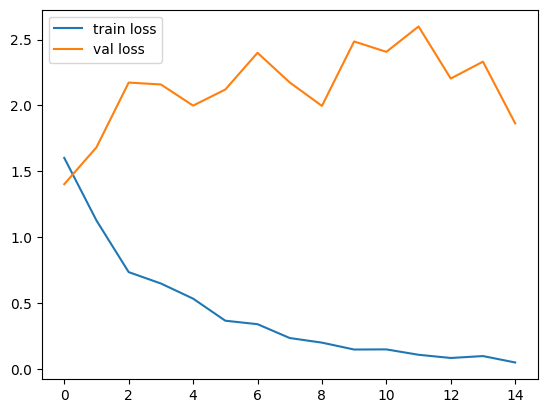

In [52]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossVal_loss')
plt.show()